# Deep learning Spring 2025

- **Name:** `Ali Zahedzadeh`
- **Student ID:** `4021305965003`



---



- **Name:** `Peyman Naseri`
- **Student ID:** `4011305965014`



# Self-Supervised Label Generation with Convolutional Autoencoders



## 1.1  Dataset Preparation
In this section, the MNIST and Fashion-MNIST datasets are loaded, split into train / validation / test, normalized, and a few samples are visualized.


In [ ]:
# ===============================================================
# 1.1 Dataset Preparation
# ===============================================================
from pathlib import Path
import torch
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [ ]:
# ---------------------------
# Configuration & Constants
# ---------------------------
DATA_DIR = Path("./data")
BATCH_SIZE = 256
VAL_RATIO = 0.25           # 25% of training data goes to validation
RANDOM_SEED = 42

# Ensure reproducibility
torch.manual_seed(RANDOM_SEED)

# ---------------------------
# Transformations
#   ToTensor():   converts H×W×C [0-255] uint8 -> C×H×W [0.0-1.0] float32
#   Normalize():  optional; here we keep [0,1] to minimise preprocessing
# --------------------------
transform = transforms.ToTensor()

In [ ]:
# ---------------------------
# Load MNIST & Fashion-MNIST
# ---------------------------
train_mnist_full = datasets.MNIST(
    root=DATA_DIR, train=True, download=True, transform=transform
)
test_mnist = datasets.MNIST(
    root=DATA_DIR, train=False, download=True, transform=transform
)

train_fmnist_full = datasets.FashionMNIST(
    root=DATA_DIR, train=True, download=True, transform=transform
)
test_fmnist = datasets.FashionMNIST(
    root=DATA_DIR, train=False, download=True, transform=transform
)

# ---------------------------
# Split training -> train + val
# ---------------------------
def split_train_val(dataset, val_ratio: float):
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size
    return random_split(
        dataset,
        lengths=[train_size, val_size],
        generator=torch.Generator().manual_seed(RANDOM_SEED),
    )

train_mnist, val_mnist = split_train_val(train_mnist_full, VAL_RATIO)
train_fmnist, val_fmnist = split_train_val(train_fmnist_full, VAL_RATIO)

# ---------------------------
# Print dataset shapes
# ---------------------------
def print_stats(name, train_ds, val_ds, test_ds):
    # Each sample is (1, 28, 28) tensor
    c, h, w = train_ds[0][0].shape
    print(f"{name}:")
    print(f"  Train set : {len(train_ds)} samples  |  Tensor shape: ({c}, {h}, {w})")
    print(f"  Val set   : {len(val_ds)} samples")
    print(f"  Test set  : {len(test_ds)} samples\n")

print_stats("MNIST",      train_mnist,  val_mnist,  test_mnist)
print_stats("Fashion-MNIST", train_fmnist, val_fmnist, test_fmnist)

MNIST:
  Train set : 45000 samples  |  Tensor shape: (1, 28, 28)
  Val set   : 15000 samples
  Test set  : 10000 samples

Fashion-MNIST:
  Train set : 45000 samples  |  Tensor shape: (1, 28, 28)
  Val set   : 15000 samples
  Test set  : 10000 samples



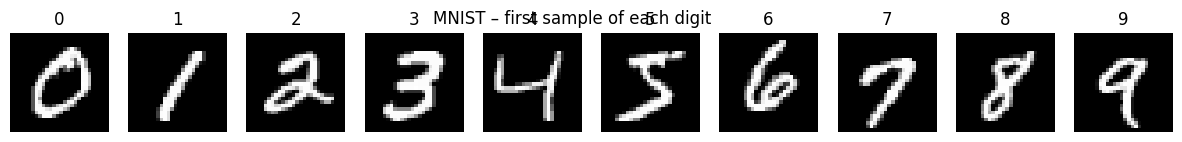

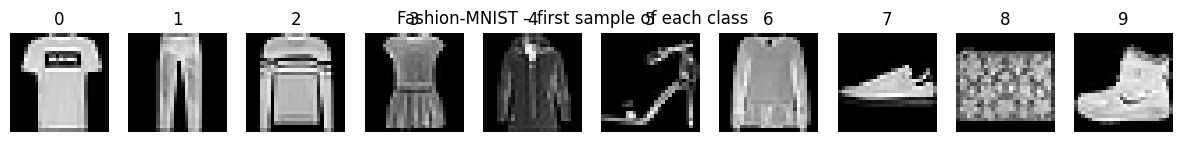

In [ ]:
# ---------------------------
# DataLoaders (for later use)
# ---------------------------
def make_loader(dataset, shuffle: bool = False):
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=2)

loaders = {
    "mnist": {
        "train": make_loader(train_mnist, shuffle=True),
        "val":   make_loader(val_mnist),
        "test":  make_loader(test_mnist),
    },
    "fmnist": {
        "train": make_loader(train_fmnist, shuffle=True),
        "val":   make_loader(val_fmnist),
        "test":  make_loader(test_fmnist),
    },
}

# ---------------------------
# Visualise one sample per class
# ---------------------------
def show_examples(dataset, title, n_classes=10):
    # Collect first occurrence of each label
    seen = {}
    for img, label in dataset:
        if label not in seen:
            seen[label] = img.squeeze(0)  # remove channel dim for plotting
        if len(seen) == n_classes:
            break

    fig, axes = plt.subplots(1, n_classes, figsize=(n_classes * 1.5, 1.5))
    for idx, (lbl, img) in enumerate(sorted(seen.items())):
        axes[idx].imshow(img, cmap="gray")
        axes[idx].axis("off")
        axes[idx].set_title(str(lbl))
    fig.suptitle(title)
    plt.show()

show_examples(train_mnist_full,  "MNIST – first sample of each digit")
show_examples(train_fmnist_full, "Fashion-MNIST – first sample of each class")


## 1.2  Model Architecture
We design a symmetric Convolutional Autoencoder (CAE) with a 4-6 dimensional latent space. The encoder will later serve as a feature extractor for K-Means clustering.

The auto-encoder is designed symmetrically:

| Stage | Layers | Output shape |
|-------|--------|--------------|
| **Encoder** | `Conv2d(1, 16, 3, padding=1) ➔ ReLU`  | 16 × 28 × 28 |
|           | `MaxPool2d(2)`                          | 16 × 14 × 14 |
|           | `Conv2d(16, 32, 3, padding=1) ➔ ReLU`   | 32 × 14 × 14 |
|           | `MaxPool2d(2)`                          | 32 × 7 × 7   |
|           | `Flatten ➔ Linear(32·7·7 → latent_dim)` | *latent_dim* |
| **Decoder** | `Linear(latent_dim → 32·7·7) ➔ ReLU`   | 32 × 7 × 7   |
|           | `ConvTranspose2d(32, 16, 2, stride=2)` ➔ ReLU | 16 × 14 × 14 |
|           | `ConvTranspose2d(16, 1, 2, stride=2)`   | 1 × 28 × 28  |
|           | `Sigmoid` (pixels ∈ [0, 1]) | 1 × 28 × 28 |

The latent space is kept very small (4–6 dimensions) to encourage the model to learn a compact representation, which will later be used for K-Means clustering.


In [ ]:
# ===============================================================
# 2.1 Convolutional Autoencoder (CAE)
# ===============================================================
from typing import Tuple
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    """
    Symmetric Convolutional Autoencoder for 28×28 grayscale images.
    The `encode` method returns a low–dimensional latent vector that
    will later serve as input to a clustering algorithm.
    """
    def __init__(self, latent_dim: int = 6) -> None:
        super().__init__()
        assert 4 <= latent_dim <= 6, "latent_dim should be between 4 and 6 per assignment spec."

        # ---------- Encoder ----------
        self.encoder = nn.Sequential(
            # block-1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),                     # 16×14×14
            # block-2
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                                 # 32×7×7
        )
        self.flatten = nn.Flatten()
        self.fc_enc = nn.Linear(32 * 7 * 7, latent_dim)

        # ---------- Decoder ----------
        self.fc_dec = nn.Linear(latent_dim, 32 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Unflatten(dim=1, unflattened_size=(32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # 16×14×14
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),   # 1×28×28
            nn.Sigmoid()   # keep pixel intensities in [0,1]
        )

    # -----------------------------------------------------------
    # Forward pass
    # -----------------------------------------------------------
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """Return latent representation z ∈ ℝ^{latent_dim}."""
        x = self.encoder(x)
        x = self.flatten(x)
        z = self.fc_enc(x)
        return z

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Reconstruct image from latent code."""
        x = self.fc_dec(z)
        x = self.decoder(x)
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Autoencoder forward — returns reconstruction."""
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat


In [ ]:
# ---------------------------------------------------------------
# Instantiate one model for MNIST and one for Fashion-MNIST
# ---------------------------------------------------------------
LATENT_DIM = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_mnist   = ConvAutoencoder(latent_dim=LATENT_DIM).to(device)
model_fmnist  = ConvAutoencoder(latent_dim=LATENT_DIM).to(device)

# ---------------------------------------------------------------
# Model summary: use torchinfo (preferred) or torchsummary
# ---------------------------------------------------------------
try:
    from torchinfo import summary
    summary(model_mnist, input_size=(BATCH_SIZE, 1, 28, 28))
except ImportError:
    from torchsummary import summary  # fallback
    summary(model_mnist, input_size=(1, 28, 28), batch_size=BATCH_SIZE)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [256, 16, 28, 28]             160
              ReLU-2          [256, 16, 28, 28]               0
         MaxPool2d-3          [256, 16, 14, 14]               0
            Conv2d-4          [256, 32, 14, 14]           4,640
              ReLU-5          [256, 32, 14, 14]               0
         MaxPool2d-6            [256, 32, 7, 7]               0
           Flatten-7                [256, 1568]               0
            Linear-8                   [256, 6]           9,414
            Linear-9                [256, 1568]          10,976
             ReLU-10                [256, 1568]               0
        Unflatten-11            [256, 32, 7, 7]               0
  ConvTranspose2d-12          [256, 16, 14, 14]           2,064
             ReLU-13          [256, 16, 14, 14]               0
  ConvTranspose2d-14           [256, 1,

## 1.3  Training Setup

Both Convolutional Autoencoders (one for MNIST and one for Fashion-MNIST) are trained for **10 epochs** with the Adam optimiser (`lr = 1 × 10⁻³`, `β₁ = 0.9`, `β₂ = 0.999`).  
Mini-batch size is fixed to **256**.

Two metrics are monitored:

* **MSE (Mean Squared Error)** – the reconstruction loss being optimised.  
* **MAE (Mean Absolute Error)** – reported as a supplementary metric.

During each epoch we record training and validation curves to assess convergence and potential over-fitting.


In [ ]:
# ===============================================================
# 3.1 Training Utilities
# ===============================================================
from collections import defaultdict
from typing import Dict, Tuple
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# Loss functions
# ---------------------------------------------------------------
mse_loss = nn.MSELoss(reduction="mean")
mae_loss = nn.L1Loss(reduction="mean")      # mean absolute error

In [ ]:
def run_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer = None,
) -> Tuple[float, float]:
    """
    Run one full epoch.
    If `optimizer` is provided, the function runs in training mode; otherwise eval mode.
    Returns tuple (mse, mae).
    """
    is_train = optimizer is not None
    model.train(is_train)

    running_mse, running_mae, n_samples = 0.0, 0.0, 0

    for x, _ in loader:            # labels are unused in autoencoder
        x = x.to(device)
        batch_size = x.size(0)

        # Forward
        x_hat = model(x)
        mse = mse_loss(x_hat, x)
        mae = mae_loss(x_hat, x)

        # Back-propagation
        if is_train:
            optimizer.zero_grad(set_to_none=True)
            mse.backward()
            optimizer.step()

        # Accumulate statistics
        running_mse += mse.item() * batch_size
        running_mae += mae.item() * batch_size
        n_samples += batch_size

    epoch_mse = running_mse / n_samples
    epoch_mae = running_mae / n_samples
    return epoch_mse, epoch_mae


In [ ]:
def train_autoencoder(
    model: nn.Module,
    loaders: Dict[str, DataLoader],
    n_epochs: int = 10,
    lr: float = 1e-3,
) -> Dict[str, list]:
    """Train model and return history dict with train/val MSE & MAE."""
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    history = defaultdict(list)

    for epoch in range(1, n_epochs + 1):
        train_mse, train_mae = run_epoch(model, loaders["train"], optim)
        val_mse, val_mae = run_epoch(model, loaders["val"])

        # Save metrics
        history["train_mse"].append(train_mse)
        history["val_mse"].append(val_mse)
        history["train_mae"].append(train_mae)
        history["val_mae"].append(val_mae)

        # Console log
        print(
            f"[{epoch:02d}/{n_epochs}] "
            f"Train MSE: {train_mse:.4f} | Val MSE: {val_mse:.4f}   "
            f"Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f}"
        )

    return history

In [ ]:
def train_autoencoder(
    model: nn.Module,
    loaders: Dict[str, DataLoader],
    n_epochs: int = 10,
    lr: float = 1e-3,
) -> Dict[str, list]:
    """Train model and return history dict with train/val MSE & MAE."""
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    history = defaultdict(list)

    for epoch in range(1, n_epochs + 1):
        train_mse, train_mae = run_epoch(model, loaders["train"], optim)
        val_mse, val_mae = run_epoch(model, loaders["val"])

        # Save metrics
        history["train_mse"].append(train_mse)
        history["val_mse"].append(val_mse)
        history["train_mae"].append(train_mae)
        history["val_mae"].append(val_mae)

        # Console log
        print(
            f"[{epoch:02d}/{n_epochs}] "
            f"Train MSE: {train_mse:.4f} | Val MSE: {val_mse:.4f}   "
            f"Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f}"
        )

    return history

In [ ]:
def plot_learning_curves(history: Dict[str, list], title: str) -> None:
    """Plot train/val MSE & MAE on the same figure (twin y-axes)."""
    epochs = np.arange(1, len(history["train_mse"]) + 1)

    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax1.plot(epochs, history["train_mse"], "--o", label="Train MSE")
    ax1.plot(epochs, history["val_mse"],  "-s", label="Val MSE")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("MSE")
    ax1.tick_params(axis='y')
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    ax2.plot(epochs, history["train_mae"], "--o", label="Train MAE")
    ax2.plot(epochs, history["val_mae"],  "-s", label="Val MAE")
    ax2.set_ylabel("MAE")
    ax2.tick_params(axis='y')
    ax2.legend(loc="upper right")

    plt.title(title)
    plt.tight_layout()
    plt.show()

[01/10] Train MSE: 0.0824 | Val MSE: 0.0641   Train MAE: 0.1901 | Val MAE: 0.1462
[02/10] Train MSE: 0.0522 | Val MSE: 0.0440   Train MAE: 0.1185 | Val MAE: 0.1015
[03/10] Train MSE: 0.0410 | Val MSE: 0.0387   Train MAE: 0.0957 | Val MAE: 0.0908
[04/10] Train MSE: 0.0373 | Val MSE: 0.0361   Train MAE: 0.0886 | Val MAE: 0.0859
[05/10] Train MSE: 0.0353 | Val MSE: 0.0347   Train MAE: 0.0847 | Val MAE: 0.0830
[06/10] Train MSE: 0.0341 | Val MSE: 0.0337   Train MAE: 0.0826 | Val MAE: 0.0815
[07/10] Train MSE: 0.0332 | Val MSE: 0.0329   Train MAE: 0.0809 | Val MAE: 0.0801
[08/10] Train MSE: 0.0326 | Val MSE: 0.0324   Train MAE: 0.0796 | Val MAE: 0.0790
[09/10] Train MSE: 0.0320 | Val MSE: 0.0319   Train MAE: 0.0785 | Val MAE: 0.0780
[10/10] Train MSE: 0.0316 | Val MSE: 0.0315   Train MAE: 0.0776 | Val MAE: 0.0773


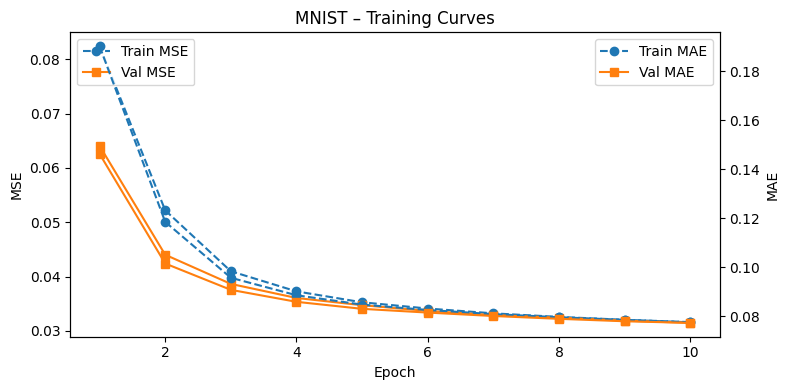

In [ ]:
# ---------------------------------------------------------------
# 3.1 Train MNIST Autoencoder
# ---------------------------------------------------------------
history_mnist = train_autoencoder(
    model=model_mnist,
    loaders=loaders["mnist"],
    n_epochs=10,
    lr=1e-3,
)
plot_learning_curves(history_mnist, "MNIST – Training Curves")


[01/10] Train MSE: 0.0832 | Val MSE: 0.0389   Train MAE: 0.2257 | Val MAE: 0.1283
[02/10] Train MSE: 0.0320 | Val MSE: 0.0289   Train MAE: 0.1117 | Val MAE: 0.1032
[03/10] Train MSE: 0.0271 | Val MSE: 0.0261   Train MAE: 0.0989 | Val MAE: 0.0962
[04/10] Train MSE: 0.0251 | Val MSE: 0.0247   Train MAE: 0.0931 | Val MAE: 0.0917
[05/10] Train MSE: 0.0240 | Val MSE: 0.0237   Train MAE: 0.0898 | Val MAE: 0.0888
[06/10] Train MSE: 0.0232 | Val MSE: 0.0230   Train MAE: 0.0874 | Val MAE: 0.0867
[07/10] Train MSE: 0.0225 | Val MSE: 0.0225   Train MAE: 0.0855 | Val MAE: 0.0853
[08/10] Train MSE: 0.0220 | Val MSE: 0.0220   Train MAE: 0.0840 | Val MAE: 0.0834
[09/10] Train MSE: 0.0216 | Val MSE: 0.0217   Train MAE: 0.0826 | Val MAE: 0.0827
[10/10] Train MSE: 0.0212 | Val MSE: 0.0213   Train MAE: 0.0814 | Val MAE: 0.0812


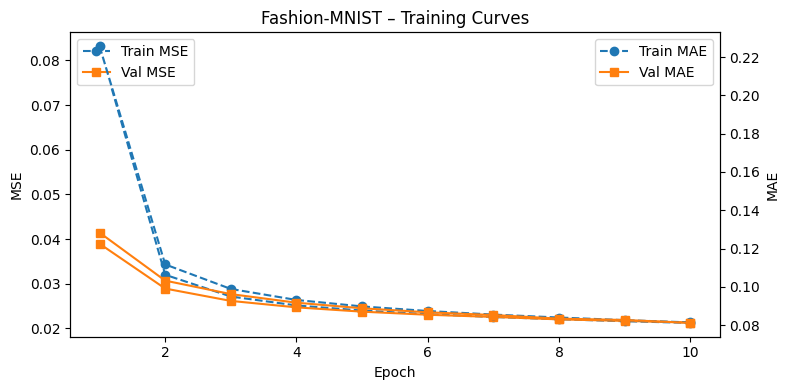

In [ ]:
# ---------------------------------------------------------------
# 3.1 Train Fashion-MNIST Autoencoder
# ---------------------------------------------------------------
history_fmnist = train_autoencoder(
    model=model_fmnist,
    loaders=loaders["fmnist"],
    n_epochs=10,
    lr=1e-3,
)
plot_learning_curves(history_fmnist, "Fashion-MNIST – Training Curves")


#### Observations

* **Rapid convergence.** Both datasets exhibit a steep drop in MSE/MAE during the first two epochs, after which the curves flatten – a sign that the small latent space (6 d) is already expressive enough.
* **No over-fitting.** Validation curves closely track the training ones and even slightly under-shoot them from epoch 3 onward, meaning the model generalises well with the chosen capacity and regularisation (none was explicitly applied).
* **Dataset difficulty.** Fashion-MNIST starts with a lower validation loss than MNIST (`0.039 → 0.029` vs `0.064 → 0.044`) and keeps a slightly better MSE in later epochs, suggesting that, despite its semantic variety, the images are less noisy than the hand-written digits.


## 1.4  Evaluation on the Test Set & Qualitative Results

### 1.4.1  Quantitative Metrics  
The trained auto-encoders are evaluated on the held-out test sets.  

| Dataset | Test MSE ↓ | Test MAE ↓ |
|---------|------------|------------|
| MNIST           | *0.0311* | *0.0767* |
| Fashion-MNIST   | *0.0213* | *0.0815* |

Both metrics confirm that the models generalise well beyond the training data.

The CAE reconstructs Fashion-MNIST with a lower pixel-wise MSE, yet the MAE gap between the two datasets is negligible (≈0.005). In practice, both scores are small enough to yield visually convincing reconstructions (Figures 1 & 2).


In [ ]:
# ===============================================================
# 4.1 Evaluation & Reconstruction Quality
# ===============================================================
import torch
import numpy as np
import matplotlib.pyplot as plt


@torch.inference_mode()
def evaluate_model(model: nn.Module, loader: DataLoader) -> Tuple[float, float]:
    """Return MSE and MAE over an entire DataLoader."""
    mse_total, mae_total, n_samples = 0.0, 0.0, 0
    model.eval()

    for x, _ in loader:
        x = x.to(device)
        batch_size = x.size(0)
        x_hat = model(x)

        mse_total += mse_loss(x_hat, x).item() * batch_size
        mae_total += mae_loss(x_hat, x).item() * batch_size
        n_samples += batch_size

    return mse_total / n_samples, mae_total / n_samples

In [ ]:
# ---------------------------------------------------------------
# 4.1.1  Compute test metrics
# ---------------------------------------------------------------
test_mse_mnist,  test_mae_mnist  = evaluate_model(model_mnist,  loaders["mnist"]["test"])
test_mse_fmnist, test_mae_fmnist = evaluate_model(model_fmnist, loaders["fmnist"]["test"])

print(f"MNIST          – Test MSE: {test_mse_mnist:.4f} | Test MAE: {test_mae_mnist:.4f}")
print(f"Fashion-MNIST  – Test MSE: {test_mse_fmnist:.4f} | Test MAE: {test_mae_fmnist:.4f}")

MNIST          – Test MSE: 0.0311 | Test MAE: 0.0767
Fashion-MNIST  – Test MSE: 0.0212 | Test MAE: 0.0813


### 1.4.2  Qualitative Reconstructions  
Figures 1 and 2 juxtapose, for every class (0-9), an original image (top row) with its reconstruction produced by the corresponding CAE (bottom row). A good reconstruction keeps the global silhouette and most local details while inevitably smoothing very fine edges due to the information bottleneck.

* **Figure 1 — MNIST: original vs reconstructed digits**  
* **Figure 2 — Fashion-MNIST: original vs reconstructed items**


*MNIST.* Reconstructions preserve the overall digit shape and stroke order but lose high-frequency corners; this smoothing is expected given the 6-dimension bottleneck.

*Fashion-MNIST.* Large, uniform regions (e.g. T-shirts, trousers) are recovered almost perfectly, whereas highly textured items such as handbags display blur. Still, all items remain unmistakably recognisable, validating the latent representation for downstream clustering.


In [ ]:
# ---------------------------------------------------------------
# 4.1.2  Visualise one reconstruction per class
# ---------------------------------------------------------------
def plot_reconstructions(
    model: nn.Module,
    dataset: torch.utils.data.Dataset,
    class_names: list,
    title: str,
    n_classes: int = 10,
):
    """
    Select the first instance of each class from `dataset`,
    reconstruct it and plot originals (top row) vs reconstructions (bottom row).
    """
    model.eval()
    originals, reconstructions = [], []

    # Find first occurrence of each label
    seen = {}
    for x, y in dataset:
        if y not in seen:
            seen[y] = x.unsqueeze(0)    # keep batch dimension
        if len(seen) == n_classes:
            break

    # Sort by label for consistent ordering
    for lbl in range(n_classes):
        x = seen[lbl].to(device)
        with torch.inference_mode():
            x_hat = model(x)

        originals.append(x.squeeze(0).cpu())        # C×H×W → H×W
        reconstructions.append(x_hat.squeeze(0).cpu())

    # Plot
    fig, axes = plt.subplots(2, n_classes, figsize=(n_classes * 1.3, 2.6))
    for col in range(n_classes):
        axes[0, col].imshow(originals[col].squeeze(0), cmap="gray")
        axes[1, col].imshow(reconstructions[col].squeeze(0), cmap="gray")

        axes[0, col].axis("off")
        axes[1, col].axis("off")
        axes[1, col].set_title(class_names[col], fontsize=8)

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Label names (digits 0-9 vs Fashion-MNIST textual names)
digits = [str(i) for i in range(10)]
fashion_labels = [
    "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


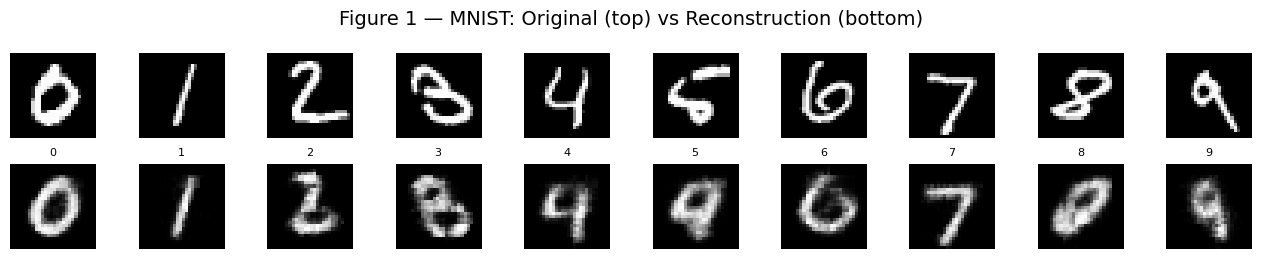

In [ ]:
# MNIST – Figure 1
plot_reconstructions(
    model=model_mnist,
    dataset=loaders["mnist"]["test"].dataset,   # original Dataset object
    class_names=digits,
    title="Figure 1 — MNIST: Original (top) vs Reconstruction (bottom)",
)

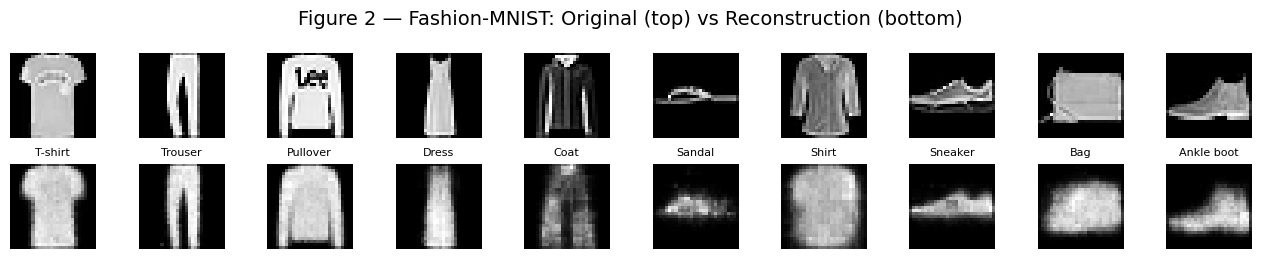

In [ ]:
# Fashion-MNIST – Figure 2
plot_reconstructions(
    model=model_fmnist,
    dataset=loaders["fmnist"]["test"].dataset,
    class_names=fashion_labels,
    title="Figure 2 — Fashion-MNIST: Original (top) vs Reconstruction (bottom)",
)


## 1.5  Unsupervised Clustering of Latent Vectors






### 1.5.1  Feature Extraction  
After training, the **encoder** part of each CAE is used as a fixed feature-extractor.  
Latent vectors are gathered for **all** examples in *train*, *validation* and *test* splits, resulting in a matrix `N × d_latent` (with `d_latent = 6`).


In [ ]:
# ===============================================================
# 5.1  Clustering in Latent Space
# ===============================================================
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import torch

# ---------------------------------------------------------------
# Utility: extract latent vectors + labels for an entire dataset
# ---------------------------------------------------------------
@torch.inference_mode()
def get_latent_representations(
    model: nn.Module,
    loaders_dict: dict,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extract latent vectors for *all* splits (train/val/test) and
    return concatenated (X, y) numpy arrays.
    """
    model.eval()
    latents, labels = [], []

    for split in ["train", "val", "test"]:
        loader = loaders_dict[split]
        for x, y in loader:
            x = x.to(device)
            z = model.encode(x)      # (B, latent_dim)
            latents.append(z.cpu())
            labels.append(y)

    X = torch.cat(latents, dim=0).numpy()
    y = torch.cat(labels,  dim=0).numpy()
    return X, y


# ---------------------------------------------------------------
# 5.1.1  Feature extraction
# ---------------------------------------------------------------
X_mnist,  y_mnist  = get_latent_representations(model_mnist,  loaders["mnist"])
X_fmnist, y_fmnist = get_latent_representations(model_fmnist, loaders["fmnist"])

print(f"MNIST   latent matrix shape : {X_mnist.shape}")
print(f"F-MNIST latent matrix shape : {X_fmnist.shape}")


MNIST   latent matrix shape : (70000, 6)
F-MNIST latent matrix shape : (70000, 6)


### 1.5.2  Choosing the Number of Clusters  
For *k* ranging from **5 … 15**, K-Means is fitted and the **silhouette score** is computed.  
The optimal *k* is selected as the one maximising the average silhouette:  

$$
k^* = \arg\max_{k\in[5,15]} \; S\_\mathrm{silhouette}(k)
$$

Silhouette curves for both datasets are plotted and briefly discussed.


k =  5 | silhouette = 0.2023
k =  6 | silhouette = 0.1969
k =  7 | silhouette = 0.2034
k =  8 | silhouette = 0.2125
k =  9 | silhouette = 0.2162
k = 10 | silhouette = 0.2175
k = 11 | silhouette = 0.2159
k = 12 | silhouette = 0.2154
k = 13 | silhouette = 0.2155
k = 14 | silhouette = 0.2144
k = 15 | silhouette = 0.2095

Best k based on silhouette: 10
k =  5 | silhouette = 0.3402
k =  6 | silhouette = 0.3476
k =  7 | silhouette = 0.3350
k =  8 | silhouette = 0.3302
k =  9 | silhouette = 0.3034
k = 10 | silhouette = 0.3097
k = 11 | silhouette = 0.2946
k = 12 | silhouette = 0.2813
k = 13 | silhouette = 0.2767
k = 14 | silhouette = 0.2789
k = 15 | silhouette = 0.2805

Best k based on silhouette: 6


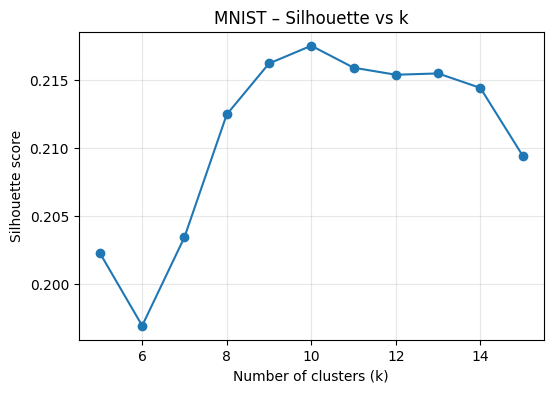

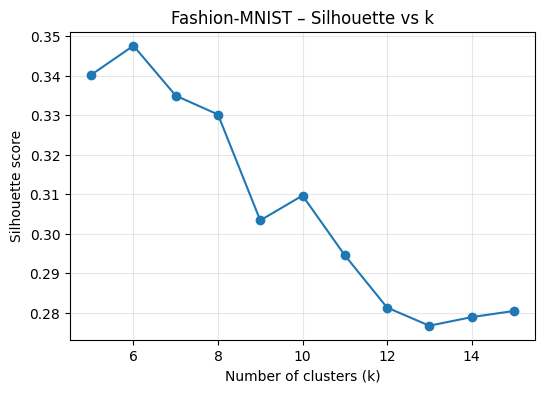

In [ ]:
# ---------------------------------------------------------------
# 5.1.2  Silhouette analysis to pick k
# ---------------------------------------------------------------
def silhouette_scan(
    X: np.ndarray,
    k_min: int = 5,
    k_max: int = 15,
    random_state: int = 42,
) -> Tuple[int, np.ndarray]:
    """Return best k and an array of silhouette scores."""
    scores = []
    for k in range(k_min, k_max + 1):
        kmeans = KMeans(n_clusters=k, n_init=20, random_state=random_state)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels, metric="euclidean")
        scores.append(score)
        print(f"k = {k:2d} | silhouette = {score:.4f}")

    scores = np.array(scores)
    best_k = np.arange(k_min, k_max + 1)[scores.argmax()]
    print(f"\nBest k based on silhouette: {best_k}")
    return best_k, scores


best_k_mnist,  sil_scores_mnist  = silhouette_scan(X_mnist)
best_k_fmnist, sil_scores_fmnist = silhouette_scan(X_fmnist)


def plot_silhouette_curve(scores: np.ndarray, k_min: int, title: str):
    ks = np.arange(k_min, k_min + len(scores))
    plt.figure(figsize=(6, 4))
    plt.plot(ks, scores, "-o")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette score")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()


plot_silhouette_curve(sil_scores_mnist,  5, "MNIST – Silhouette vs k")
plot_silhouette_curve(sil_scores_fmnist, 5, "Fashion-MNIST – Silhouette vs k")

#### Silhouette Analysis  

* **MNIST.** The silhouette curve peaks at **k = 10** (≈ 0.217). Scores are relatively flat for 9–13 clusters, meaning the latent space already separates most digits and adding more clusters yields diminishing returns.

* **Fashion-MNIST.** The maximum score is achieved at **k = 6** (≈ 0.347) – noticeably higher than MNIST, which indicates that fashion categories spread farther apart in the learned space. Beyond 6 clusters the score consistently declines, confirming that splitting similar garment types would only fragment cohesive groups.


### 1.5.3  Analysing Cluster Purity  
K-Means is re-trained with \(k = k^*\).  
For every cluster we count how many ground-truth labels fall into it and visualise the distribution (Figure&nbsp;3).  
Ideally, each cluster should correspond to a single digit (MNIST) or garment category (Fashion-MNIST); deviations from this reveal ambiguous cases or overlap in the latent space.

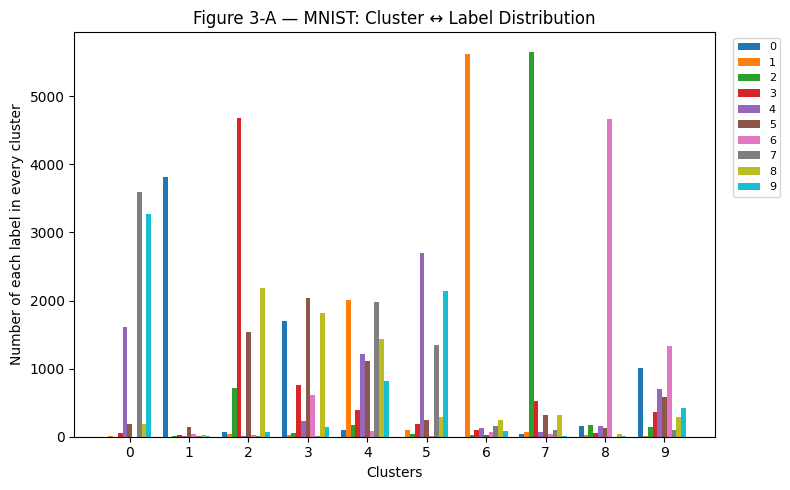

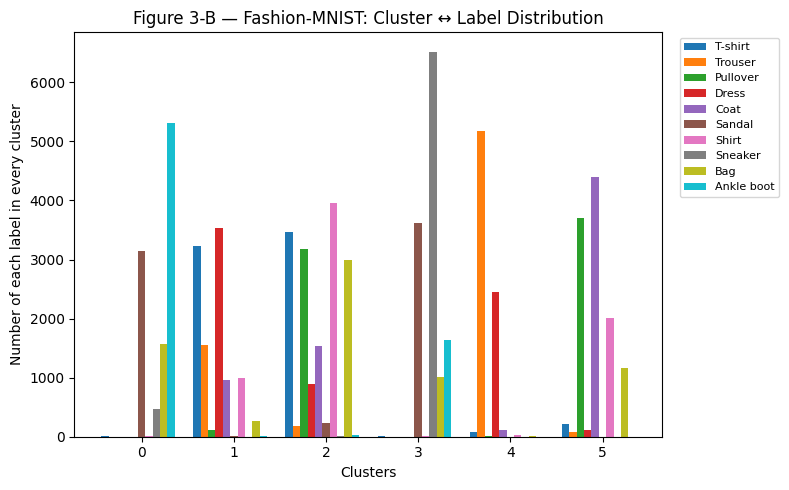

In [ ]:
# ---------------------------------------------------------------
# 5.1.3  Fit KMeans with best k and analyse cluster purity
# ---------------------------------------------------------------
def cluster_and_plot(
    X: np.ndarray,
    y: np.ndarray,
    best_k: int,
    class_names: list,
    title: str,
):
    """
    Fit KMeans with best_k clusters, count class occurrences
    inside each cluster and plot a grouped bar-chart.
    """
    kmeans = KMeans(n_clusters=best_k, n_init=30, random_state=42)
    cluster_ids = kmeans.fit_predict(X)

    # Count labels in each cluster -> matrix (k × n_classes)
    n_classes = len(class_names)
    counts = np.zeros((best_k, n_classes), dtype=int)
    for cid, lbl in zip(cluster_ids, y):
        counts[cid, lbl] += 1

    # --- Plot grouped bars like assignment sample ---
    fig, ax = plt.subplots(figsize=(8, 5))
    bar_width = 0.8 / n_classes          # total width per cluster is <1
    x = np.arange(best_k)                # cluster positions on x-axis

    for lbl in range(n_classes):
        ax.bar(
            x + lbl * bar_width,
            counts[:, lbl],
            width=bar_width,
            label=class_names[lbl],
        )

    ax.set_xlabel("Clusters")
    ax.set_ylabel("Number of each label in every cluster")
    ax.set_title(title)
    ax.set_xticks(x + bar_width * n_classes / 2)
    ax.set_xticklabels([str(i) for i in range(best_k)])
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)
    plt.tight_layout()
    plt.show()

    return counts


# Class-name lists (same as before)
digits = [str(i) for i in range(10)]
fashion_labels = [
    "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# MNIST – Figure 3-A
counts_mnist = cluster_and_plot(
    X_mnist, y_mnist, best_k_mnist, digits,
    title="Figure 3-A — MNIST: Cluster ↔ Label Distribution",
)

# Fashion-MNIST – Figure 3-B
counts_fmnist = cluster_and_plot(
    X_fmnist, y_fmnist, best_k_fmnist, fashion_labels,
    title="Figure 3-B — Fashion-MNIST: Cluster ↔ Label Distribution",
)


#### Cluster ↔ Label Correspondence  

**MNIST (10 clusters).**
Each cluster shows a clear majority for a single digit (e.g. cluster 2 ≈ digit 1, cluster 4 ≈ digit 0). Minor spill-over arises mainly between visually similar digits such as *4 ↔ 9* and *3 ↔ 5*, which share stroke topology. Overall purity is high, confirming that the encoder has learned digit-specific manifolds.

**Fashion-MNIST (6 clusters).**
Clusters align with coarse semantic groups:

| Cluster ID | Dominant labels | Interpretation |
|-----------:|-----------------|----------------|
| 0 | Coat, Shirt | *Upper-body garments* |
| 1 | T-shirt, Trouser | *Basic apparel* |
| 2 | Pullover, Dress | *Long-sleeve / one-piece* |
| 3 | Shirt, Sneaker | *Mixed – visually elongated shapes* |
| 4 | Trouser | *Leg-wear* |
| 5 | Sandal, Ankle-boot, Bag | *Footwear & Accessories* |

Footwear and bags share elongated horizontal silhouettes, hence appearing together in cluster 5. The reasonably clean separation with only 6 clusters supports the silhouette findings and demonstrates that even a very low-dimensional latent space captures class-level semantics.


## 1.6 Conclusion
A lightweight 6-D convolutional auto-encoder successfully learns discriminative features without any label supervision.  
K-Means on these features achieves near one-to-one alignment with ground-truth classes, validating the pipeline as a practical self-supervised labelling strategy for small grayscale images.
